# Live coding session 2 - routing with real-world data
### Installation
#### Terminal
```bash
git clone https://github.com/libklein/mfms-ss21
cd mfms-ss21
pip install -r requirements.txt
jupyter notebook
```

#### PyCharm
```bash
Download git repo
Open project in pycharm
```

#### [Binder](https://github.com/libklein/mfms-ss21)
 

## Aim of this session

#### Retrieving routing data from the street network

* Truncating the street network
* Calculating a distance matrix
* Saving/Reading data to/from disk (*serialization*/*deserialization*)

## Motivation

#### Graph:

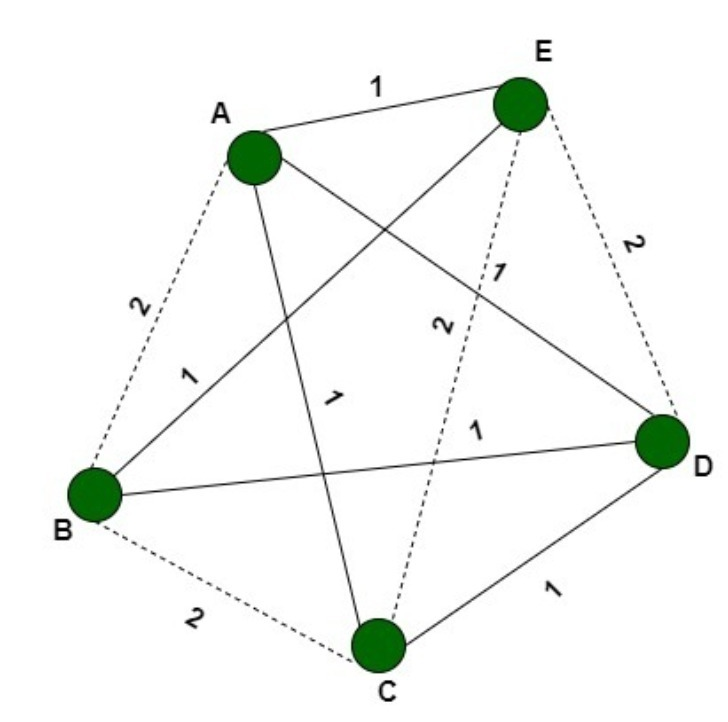

* Node for every city/point of interest
* Fully connected

#### Street network:

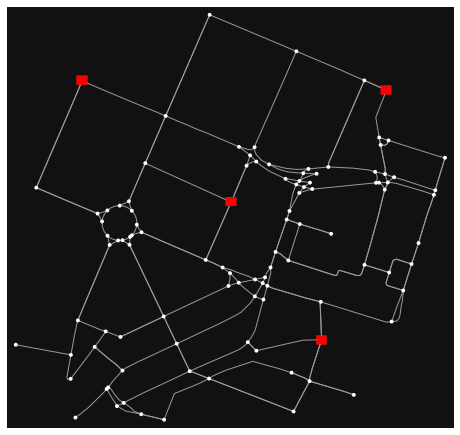

* Has node for every intersection
* Often no direct connections between nodes

**Street network requires additional processing**

## Case study

Beer bachelor:
* Pub crawl hosted in Aachen
* Drink a beer at each participating pub (10)
* Return to initial pub
* Time limit of 5 hours
* Winners graduate the beer bachelor/master/phd

Research question: **How fast do we need to drink at each pub?**

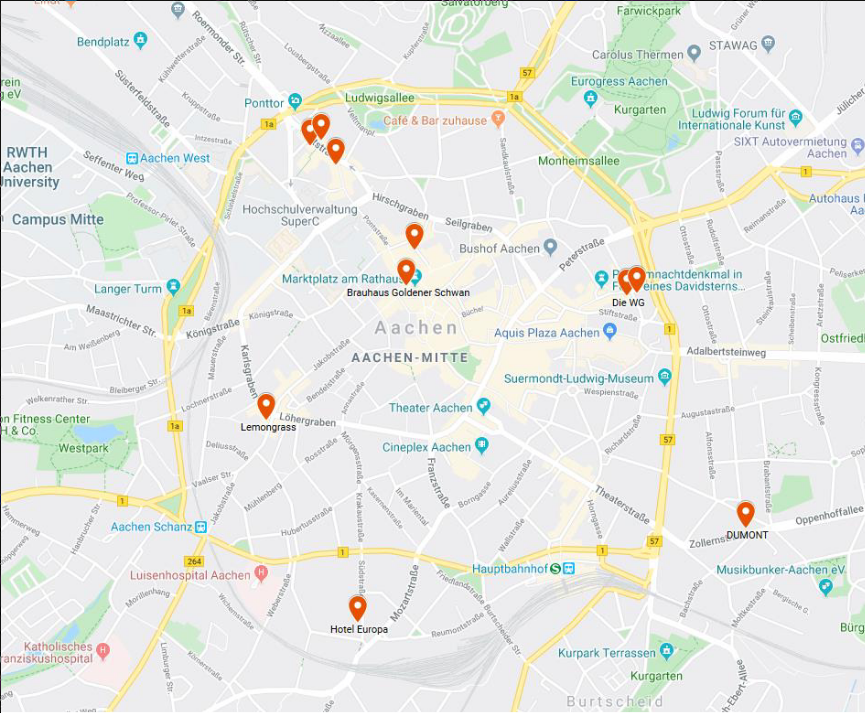

In [20]:
# Initialize imports etc.
import pandas as pd
import geopandas as gpd
import osmnx as osm
import networkx as nx
import shapely as sp
from shapely.geometry import *
from matplotlib import pyplot as plt
from matplotlib import cm

def plot_map(network, *plots, colors=cm.get_cmap('tab20').colors, show=True):
    """
    Plots GeoDataFrames or geometry on top of a street network. Each argument is plotted in a 
    different color.
    Usage: plot_map(my_network, geo_data_frame_1, ..., geo_data_frame_n)
    """
    fig, ax = osm.plot_graph(network, show=False, close=False)
    for plot, color in zip(plots, colors):
        try:
            plot.plot(ax=ax, color=color)
        except:
            try:
                gpd.GeoSeries(plot).plot(ax=ax, color=color)
            except:
                gpd.GeoSeries(plot.geometry).plot(ax=ax, color=color)

    if show:
        plt.show()
    return fig, ax

## Constructing an abstract graph from pub locations

Tasks:
* Retrieving pub locations
* Getting the street network
* Adding pubs to network
* Computing a distance matrix
* Creating fully connected pub graph

## Retrieving pub locations

Pub locations are given in csv format:
* Columns correspond to fields/properties
    * Separated by delimiter (i.e., `,`)
    * Header specifies column names
* Rows to data items
    * Separated by newlines 

In [3]:
!head pubs.csv

Name,Latitude,Longitude
Apollo,50.78067752278518,6.079017048912892
Hotel Europa,50.76662230886211, 6.081619910159788
Die WG,50.77625883773348, 6.093822431456422
Kaktus,50.780098923497775, 6.08025601399192
Kiez Kini,50.776339192160435, 6.094281410643624
Molkerei,50.78065723828593, 6.079717194815158
Nachtschicht,50.77772183142022, 6.084319038996197
Sowiso,50.78086402111629, 6.0794878876828955
Sturmfrei,50.77625044248689, 6.093587252038186


* Advantages:
    * Human readable
    * Editable with text editor
    * Easy deserialization

* Drawbacks:
    * Issues with delimiters/newlines
    * Only supports data representable as text
    * Filesize

Alternatives: JSON, parquet, HDF

## Deserializing csv files

CSV-files are supported in almost every programming language.

Python standard library: [CSV module](https://docs.python.org/3/library/csv.html)
Pandas: [read_csv](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html), [read_excel](https://pandas.pydata.org/docs/reference/api/pandas.read_excel.html)

In [4]:
pubs = pd.read_csv('pubs.csv')
pubs = gpd.GeoDataFrame(pubs, geometry=gpd.points_from_xy(pubs['Longitude'], pubs['Latitude'], crs='epsg:4326'))
pubs = osm.project_gdf(pubs)
display(pubs)

,Name,Latitude,Longitude,geometry
0,Apollo,50.780678,6.079017,POINT (294088.836 5629503.828)
1,Hotel Europa,50.766622,6.081620,POINT (294210.584 5627934.052)
2,Die WG,50.776259,6.093822,POINT (295113.025 5628971.452)
3,Kaktus,50.780099,6.080256,POINT (294173.619 5629436.053)
4,Kiez Kini,50.776339,6.094281,POINT (295145.729 5628979.113)
5,Molkerei,50.780657,6.079717,POINT (294138.095 5629499.622)
6,Nachtschicht,50.777722,6.084319,POINT (294449.564 5629160.482)
7,Sowiso,50.780864,6.079488,POINT (294122.841 5629523.249)
8,Sturmfrei,50.776250,6.093587,POINT (295096.411 5628971.171)


## Constructing an abstract graph from pub locations

Tasks:
* ~Retrieving pub locations~
* Getting the street network
* Adding pubs to network
* Computing a distance matrix
* Creating fully connected pub graph

## Getting the street network

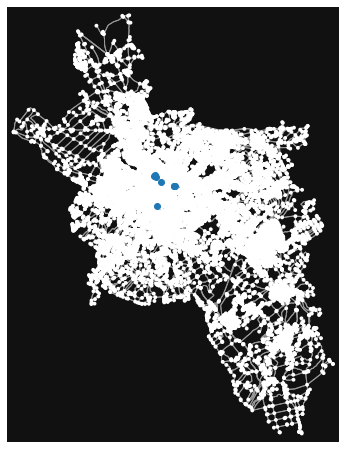

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [39]:
aachen = osm.graph_from_place('Aachen', network_type='all')
aachen = osm.project_graph(aachen)
# Plot
plot_map(aachen, pubs)

**Only a subset of the network is actually needed!**

Truncating the network is beneficial:
* Saves disk space/bandwidth
* Saves computation time (~n² calculations for distance matrix)

## Truncating the network

We want to include only the part of the network that would (reasonably) be used to travel between pubs.

Determine the area covered by a polygon encompassing all locations:

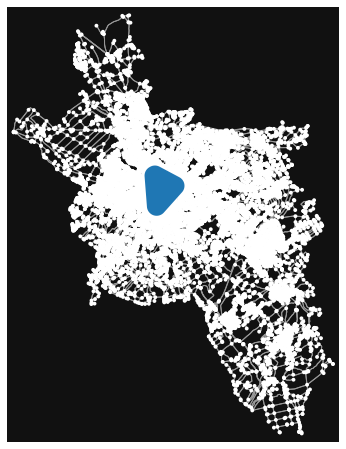

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [40]:
covered_area = pubs.unary_union.convex_hull.buffer(500)
# Plot
plot_map(aachen, covered_area)

Important considerations:
* How to find a reasonable cut-off distance?

## Fetching a street network based on a polygon

In [7]:
# Convert to lat/lon (graph_from_polygon requires lat/lon coordinates)
lat_lon_covered_area, crs = osm.projection.project_geometry(covered_area, crs=pubs.crs, to_latlong=True)

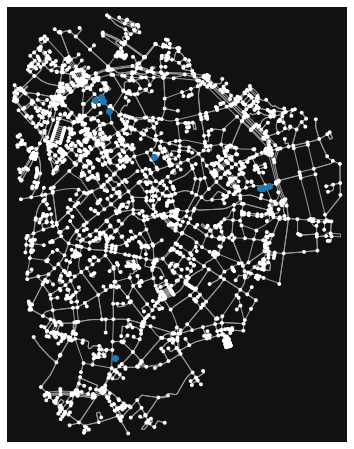

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [8]:
aachen = osm.graph_from_polygon(lat_lon_covered_area, network_type='all')
aachen = osm.project_graph(aachen)

plot_map(aachen, pubs)

Remark: The full street network is not nessesary to calculate `covered_area`. Generally, you would pull the network **based on** the calculated polygon.

## Constructing an abstract graph from pub locations

Tasks:
* ~Retrieving pub locations~
* ~Getting the street network~
* Adding pubs to network
* Computing a distance matrix
* Creating fully connected pub graph

### Merging pubs into the street network

* `osm.get_nearest_node` may produce inaccurate results
* Ideas: 
    * Connect via $n$ nearest neighbours
    * Connect via nearest edge
    * Other ideas?
* Best approach depends on problem/data

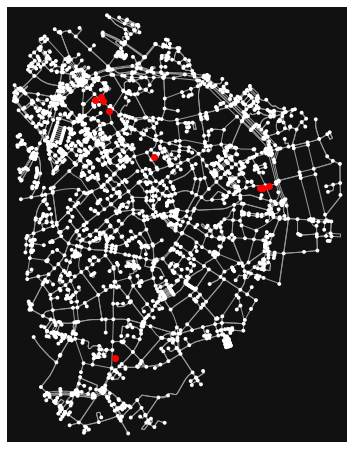

In [10]:
fig, ax = osm.plot_graph(aachen, show=False, close=False)
pubs.plot(ax=ax,color='r')
plt.show()

We assume that pubs will likely be accessible from a single street. Hence, connecting via the nearest edge is accurate enough.
* Keep in mind to reason such choices!

### Connecting via the nearest edge

Approaches:

#### Add direct connection

* Less nodes
* Easier postprocessing
* Will likely cause issues with OSMnx functions that modify edge properties

#### Add via split

* Preserves modality (e.g., does not mix walking/driving)
* Allows to use 
* Likely conflicts with OSMnx functions that modify node properties (network simplification)

Caveats:
* OSMnx creates a `MultiDiGraph`
    * Which (directed) edge between two nodes is closest *may* be arbitrary

### Adding edges in general

Replicate data OSMnx stores on edges:

In [21]:
aachen_edges = osm.graph_to_gdfs(aachen, nodes=False)
display(aachen_edges.head(n=3))

osmid  oneway    ref               name  highway  \
u         v         key                                                        
13332208  180112917 0     8082668    True  L 232  Roermonder Straße  primary   
          380759977 0    30641881    True   B 1a         Saarstraße  primary   
180112917 135578861 0    27653254    True   B 1a       Ludwigsallee  primary   

                        maxspeed  length  \
u         v         key                    
13332208  180112917 0         50   9.209   
          380759977 0         50   6.320   
180112917 135578861 0         50  13.797   

                                                                  geometry  \
u         v         key                                                      
13332208  180112917 0    LINESTRING (294014.642 5629619.517, 294010.823...   
          380759977 0    LINESTRING (294014.642 5629619.517, 294020.401...   
180112917 135578861 0    LINESTRING (294010.823 5629627.908, 294002.180...   

                        lanes service tunnel access bridge width area  
u         v         key                                                
13332208  180112917 0     NaN     NaN    NaN    NaN    NaN   NaN  NaN  
          380759977 0       2     NaN    NaN    NaN    NaN   NaN  NaN  
180112917 135578861 0       2     NaN    NaN    NaN    NaN   NaN  NaN

In [12]:
def add_edge(network: nx.DiGraph, origin, dest, dist: float, maxspeed: float, **data):
    """
    Adds an edge (including it's reversed edge) to the network.
    
    Parameters:
        network: The street network
        origin: The id of the origin node
        dest: The id of the target node
        dist: The length of the newly added edge
        maxspeed: The maximum speed of the given edge
        **data: Any additional edge attributes
    
    """
    origin_node = network.nodes[origin]
    dest_node = network.nodes[dest]
    edge = [origin, dest]
    # Geometry attribute is needed for plotting
    geometry = [sp.geometry.Point(origin_node['x'], origin_node['y']),
                           sp.geometry.Point(dest_node['x'], dest_node['y'])]
    # Add origin -> dest edge
    network.add_edge(*edge, 
                     length=dist, maxspeed=maxspeed,
                     geometry=sp.geometry.LineString(geometry), **data)
    # Add dest -> origin edge
    network.add_edge(*reversed(edge), 
                     length=dist, maxspeed=maxspeed,
                     geometry = sp.geometry.LineString(reversed(geometry)), **data)

### Adding via split

Approach:
* Find nearest edge
* Find point on edge with closest distance to pub
* Split the edge at that point
* Connect origin and destination nodes to new node
* Add pub node
* Connect new node to pub node
* Remove the old, direct edge (opt.)

In [13]:
# Adds a node by splitting an existing edge
def connect_pub_to_street_network_via_split(network, pub):
    # Copy the network
    new_network = network.copy() # Be careful!
    
    # Find nearest edge
    *nearest_edge, edge_geometry, distance_to_edge = osm.get_nearest_edge(
        new_network, (pub.geometry.y, pub.geometry.x), return_geom=True, return_dist=True)
    
    # Project to closest point on edge
    closest_point_on_edge = edge_geometry.interpolate(edge_geometry.project(pub.geometry))
    #plot_map(network, closest_point_on_edge, pub)
    
    # Split edge
    #     Add split node
    halfway_point = f'{nearest_edge[0]}-{pub.Name}-{nearest_edge[1]}'
    new_network.add_node(halfway_point, x=closest_point_on_edge.x, y=closest_point_on_edge.y)
    
    #     Connect origin and destination points to new node
    for endpoint in (nearest_edge[0], nearest_edge[1]):
        endpoint_node = new_network.nodes[endpoint]
        distance_from_endpoint = abs(edge_geometry.project(Point(endpoint_node['x'], endpoint_node['y']))
                                    - edge_geometry.project(closest_point_on_edge))
        add_edge(new_network, endpoint, halfway_point,
                 dist=distance_from_endpoint, maxspeed=5.0)
        
    # Add pub node to graph
    new_network.add_node(pub.Name, x=pub.geometry.x, y=pub.geometry.y)
    pub_node = new_network.nodes[pub.Name]
    
    # Connect split node to pub
    add_edge(new_network, halfway_point, pub.Name, dist=distance_to_edge, maxspeed=5.0)
    #plot_map(new_network)
    
    # Remove direct connection (optional)
    new_network.remove_edge(*nearest_edge)
    
    #print('Pub adj: ', new_network.adj[pub.Name])
    #print('Halfway adj: ', new_network.adj[halfway_point])
    return new_network
    
connect_pub_to_street_network_via_split(network=aachen, pub=pubs.iloc[1])

#### Adding by direct connection

In [38]:
# Adds a pub via direct connection
def connect_pub_to_street_network_directly(network, pub):
    new_network = network.copy()
    *nearest_edge, edge_geometry, distance_to_edge = osm.get_nearest_edge(
        new_network, (pub.geometry.y, pub.geometry.x), return_geom=True, return_dist=True)
    # Project to closest point on edge
    closest_point_on_edge = edge_geometry.interpolate(edge_geometry.project(pub.geometry))
    #plot_map(network, closest_point_on_edge, pub)
    
    # Add node to graph
    new_network.add_node(pub.Name, x=pub.geometry.x, y=pub.geometry.y)
    pub_node = new_network.nodes[pub.Name]
    
    edge_speed = float(new_network.edges[nearest_edge]['maxspeed'])
    # Add edge from origin/dest to pub
    for endpoint in (nearest_edge[0], nearest_edge[1]):
        endpoint_node = new_network.nodes[endpoint]
        distance_from_endpoint = abs(edge_geometry.project(Point(endpoint_node['x'], endpoint_node['y']))
                                    - edge_geometry.project(closest_point_on_edge))
        
        total_distance = distance_from_endpoint + distance_to_edge
        
        # We will travel a fraction of (distance_from_endpoint / total_distance) at edge speed
        # and a fraction of (distance_to_edge / total_distance) at walking speed
        interpolated_maxspeed = edge_speed * (distance_from_endpoint/total_distance) + 5.0 * (distance_to_edge/total_distance)
        add_edge(new_network, endpoint, pub.Name,
                 dist=distance_from_endpoint + distance_to_edge, 
                 maxspeed=interpolated_maxspeed)
    
    return new_network

connect_pub_to_street_network_directly(network=aachen, pub=pubs.iloc[1])

### Limitations

Both implementations have some limitations
* One-way streets are not handled
* Node attributes are not set
* Edge attributes are lost (direct connection)

### Adding pubs to the network

In [ ]:
# Add each pub to the network
aachen_with_pubs = aachen
for pub in pubs.iloc:
    aachen_with_pubs = connect_pub_to_street_network_via_split(aachen_with_pubs, pub)

osm.plot_graph(aachen_with_pubs, node_color=['w' if node in aachen else 'r' for node in aachen_with_pubs])

Finally compute travel times as discussed in last session:

In [ ]:
aachen_with_pubs = osm.add_edge_speeds(aachen_with_pubs)
aachen_with_pubs = osm.add_edge_travel_times(aachen_with_pubs)
# Notice the newly added travel_time and speed_kph fields.
display(osm.graph_to_gdfs(aachen_with_pubs, nodes=False))

## Constructing an abstract graph from pub locations

Tasks:
* ~Retrieving pub locations~
* ~Getting the street network~
* ~Adding pubs to network~
* Computing a distance matrix
* Creating fully connected pub graph

### Compute pairwise travel times

We can now use the `shortest_path` function to compute shortest paths.

In [ ]:
travel_time_matrix = {}
for pub_i in pubs.iloc:
    # May not be symmetric!
    for pub_j in pubs.iloc:
        shortest_path = osm.shortest_path(aachen_with_pubs, pub_i.Name, pub_j.Name, weight='travel_time')
        travel_time = sum(osm.utils_graph.get_route_edge_attributes(aachen_with_pubs, shortest_path, attribute='travel_time', minimize_key='travel_time'))
        travel_time_matrix[pub_i.Name, pub_j.Name] = travel_time
display(travel_time_matrix)

## Constructing an abstract graph from pub locations

Tasks:
* ~Retrieving pub locations~
* ~Getting the street network~
* ~Adding pubs to network~
* ~Computing a distance matrix~
* Creating fully connected pub graph

### Creating the pub graph from the distance matrix

In [ ]:
pub_graph = nx.DiGraph()

pub_graph.add_nodes_from(pubs.Name.values)
pub_graph.add_weighted_edges_from([(*edge, weight) for edge, weight in travel_time_matrix.items()], weight='travel_time')

# Plot the graph - including edge labels
pos = nx.spring_layout(pub_graph)
nx.draw_networkx(pub_graph, pos=pos, with_labels=True)
edge_labels={(i, j): round(travel_time, 2) for i, j, travel_time in pub_graph.edges.data('travel_time')}
_ = nx.draw_networkx_edge_labels(pub_graph, pos=pos, edge_labels=edge_labels)

**Caveat**: May not satisfy triangular inequality!

Final remark: You should generally save *as much information as possible* on nodes/arcs.

### Serializing the graph

Save the graph to disk so we don't need to redo all these calulations every time.

NetworkX supports a variety of formats:

| Property       | Adjacency List | Edge List      | Pickle          | GEXF      | GML           | GraphML   | JSON              |
| :- | :-: | :-: | :-: | :-: | :-: | :-: | :-: |
| Human Readable |        +       |        +       |        -        |     +     |       +       |     +     |         +         |
| Supports data  |        -       |    Text-only   |        +        | Text-only |   Text-only   | Text-only | (Text-only) |
| Attributes  |        -       |    Weight   |        +        | + |   (+)   | + | + |
| Use case       | Manual editing | Manual editing | Complex objects |  Drawing  | Compatibility |  Drawing  |  Drawing (d3.js)  |

## Examples

In [ ]:
nx.write_gpickle(pub_graph, '/tmp/graph.gpickle')

!head /tmp/graph.gexf

In [ ]:
g = nx.read_gpickle('/tmp/graph.gpickle')

display(g.adj)

Remark: One could also save the street network here or include additional information on the paths responsible for the distance. This will make visualization easier.

## Serializing non-graph data

* Is your data (naturally) representible as rows/columns?
    * Use `CSV`
* (Many) relations between individual data items?
    * Use `JSON`
* Complex objects not representible by text?
    * Use `Pickle`
    

In [19]:
import json
import csv
import pickle

data = [{'Name': 'Patrick', 'Role': 'Tutor'}, {'Name': 'Max', 'Role': 'Professor'}]

# Write to json
with open('data.json', 'w') as json_file:
    json.dump(data, json_file)
    
# Write to pickle
with open('data.pickle', 'wb') as pickle_file:
    pickle.dump(data, pickle_file)
    
# Write to csv
with open('data.csv', 'w') as csv_file:
    csv_writer = csv.DictWriter(csv_file, fieldnames=data[0].keys())
    csv_writer.writeheader()
    csv_writer.writerows(data)